In [1]:
%matplotlib inline

In [87]:
import numpy as np
import time
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd
import random

sns.set(style="whitegrid")

# You may load the dataset from URL (instead of the local file) if you wish
auto_mpg_data = "https://raw.githubusercontent.com/fundamentals-of-data-science/datasets/master/auto-mpg.data.txt"
auto_mpg_names = "https://raw.githubusercontent.com/fundamentals-of-data-science/datasets/master/auto-mpg.names.txt"

# Problem Set 5.2


This is the second part of the Problem Set. In this part you will apply Linear Regression and Model Evaluation to a same data set as Part 1.
Each part is a separate grade.


## Directions

1. Show all work/steps/calculations using a combination of code and Markdown. You will submit only this notebook named: [jhed_id].ipynb back to Blackboard from whence you downloaded it. Do not return the data to me.
2. **All** work is to be your own. This is not a group project. You may, however, use code from the lectures and labs. Provide citations for any code that is not your own. You may also consult Stackoverflow, etc. This is not by any means "closed book" or anything like that. Basically, I need to see if *you* learned the concepts from the Lectures, *Fundamentals*, and Labs.
3. Add whatever markdown or code cells you need in each part to explain and calculate your answers. Don't just provide answers but explain them as well. **Explain and interpret your results.**


<div style="background: lemonchiffon; margin:20px; padding: 20px;">
    <strong>Note</strong>
    <p>This part of the Problem Set covers Labs 9, 10, and 11 (and the corresponding course materials). However, principles covered in previous modules are still relevant (visualization, probability, etc.).</p>
    <p>Additionally, this is a <em>report</em>, a narrative description of your process and findings. Use full sentences. Limit bullet lists. You should be able to "hide code" and have the remaining text make sense.</p></div>


## Introduction

Labs 9, 10, and 11 were all about linear models, specifically linear and logistic regression, and evaluation. We learned how to build and interpret multivariate models by using domain knowledge, comparing the predicted and actual values of the coefficients and the credible intervals, and looking at residuals. We also applied transformations to make the models perform better and increase interpretability. However, please remember all previous modules are in affect. For example, you should use all our rules for visualization. ETL involves only data acquisition and *cleaning*.

Using the techniques covered during Modules 9 and 10 (lectures, labs, course notes), **build, describe, and use** a linear regression model that estimates the target variable `mpg` for the accompanying auto data set. Again, Module 11's content is probably relevant.

Do **not** use any feature selection techniques or anything other than linear regression. **Follow the method described in class.**

The instructions say **build**, **describe**, and **use**. You must describe all aspects of your final model (all the parameters and metrics) and use it to make three predictions as described in the course notes.

## 1.1 - ETL

* Copy from Part 1

Let's first start by taking a look at the data and names files we've read in. Since these are text files, I'm going to manually take a quick peek at these files.

From our names file, we have our attribute information for our data.

```
Description of fields in auto mpg data.

Name            Data Type
----            ---------
mpg             continuous
cylinders       multi-valued discrete
displacement    continuous
horsepower      continuous
weight          continuous
acceleration    continuous
model year      multi-valued discrete
origin          multi-valued discrete
car name        string (unique for each instance)
```

So we have 9 different variables in this dataset (most appear to be numeric). We know from our names file that there should be 398 instances/observations, and the $horsepower$ variable has 6 missing values.

Our first step should be getting our data into tidy data. Since there is an inconsistent amount of whitespace between each entry for any particular observation, we can tell our `pd.read_csv()` method to consider any whitespace between a value as a separator. (I initially used the `delim_whitespace=True` parameter, though that seems to be depreciated in favor of `\s+` now).

Since there are no headers in this text file, I will manually add the columns to our dataframe, using the description that we found above in our names file.

In [3]:
columns = [
    'mpg', 
    'cylinders', 
    'displacement', 
    'horsepower',
    'weight', 
    'acceleration', 
    'model year',
    'origin', 
    'car name'
]

data = pd.read_csv(auto_mpg_data, sep='\s+', header=None, names=columns)

We'll check the first few entries to make sure our data has been read in properly.

In [4]:
data.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,ford torino


Looks like we got most of what we need. We have 9 columns to represent each feature/attribute. We can also look at the information provided here with the `info()` method.

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   displacement  398 non-null    float64
 3   horsepower    398 non-null    object 
 4   weight        398 non-null    float64
 5   acceleration  398 non-null    float64
 6   model year    398 non-null    int64  
 7   origin        398 non-null    int64  
 8   car name      398 non-null    object 
dtypes: float64(4), int64(3), object(2)
memory usage: 28.1+ KB


We do in fact see 398 rows for each attribute. Most variables are floats or integers, with the exceptions of $horsepower$ and $car name$, the latter which we expect to be strings, so this is not unexpected. But we know $horsepower$ has 6 missing values somewhere. How should we handle this? I'm going to simply look at our observations first, where $horsepower$ does not have a value (from peeking at the data text file, I know the missing values are coded as a '?').

In [6]:
data[data['horsepower'] == '?']

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
32,25.0,4,98.0,?,2046.0,19.0,71,1,ford pinto
126,21.0,6,200.0,?,2875.0,17.0,74,1,ford maverick
330,40.9,4,85.0,?,1835.0,17.3,80,2,renault lecar deluxe
336,23.6,4,140.0,?,2905.0,14.3,80,1,ford mustang cobra
354,34.5,4,100.0,?,2320.0,15.8,81,2,renault 18i
374,23.0,4,151.0,?,3035.0,20.5,82,1,amc concord dl


We do in fact only have 6 observations here. Because that's only (6/398) = 0.015, or about 1.5% of our data, I will consider imputation for these 6 values with the median of $horsepower$. Note I'm choosing to use median instead of the mean since the median is a more robust statistic. This should not create inliers or other data abnormalities such as loss of variation since there are only a small number of missing values. We might turn to some domain knowledge to think about whether our median is a good estimate for these missing values.

[Average Horsepower of a Car Over the Years](https://carbuzz.com/features/average-horsepower-of-a-car-over-the-years/)

In this article, we get different ranges for the average horsepower of cars in the United States, mostly broken down by decade. To summarize, the 50s started out with an average of about 100 horsepower, and only went up to about 120hp by the 80s. Later decades saw a bit of increase, where the average could be considered closer to 175hp or so, but this might at least give us an idea if we're on the mark with imputing our missing values.

I know this is kind of blending into the EDA portion a bit, so I will just replace the missing values with our median here, and as long as we have our tidy data, we can start the EDA process and go more in depth with horsepower in the next section.

We need to select all the other 392 rows that don't include the 6 missing values in order to get the median for $horsepower$.

In [7]:
data_no_missing = data[data['horsepower'] != '?']

Since the $horsepower$ variable was a mix of strings and floats, it caused all the values to become strings. We fix this below so we can perform the numpy operations on this column.

In [8]:
data_no_missing['horsepower'] = data_no_missing['horsepower'].astype('float64')

C:\Users\Jhirs\AppData\Local\Temp\ipykernel_24120\1856811709.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_no_missing['horsepower'] = data_no_missing['horsepower'].astype('float64')


Here we can finally find the median of $horsepower$ without the missing values. 

In [9]:
np.median(data_no_missing['horsepower'])

93.5

It's 93.5, which seems like a reasonable guess for our missing values, if not slightly on the low side, remembering that we theorized average car horsepowers range between 100-200, very roughly. (Again, we could also look at the median model years for the cars to get a better rough estimate, but I think that's getting too much into the EDA portion of things).

Finally, we can replace our missing values with our median of 93.5 and convert the column into a float type to prepare for our EDA.

In [10]:
data = data.replace('?', '93.5')
data['horsepower'] = data['horsepower'].astype('float64')

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   displacement  398 non-null    float64
 3   horsepower    398 non-null    float64
 4   weight        398 non-null    float64
 5   acceleration  398 non-null    float64
 6   model year    398 non-null    int64  
 7   origin        398 non-null    int64  
 8   car name      398 non-null    object 
dtypes: float64(5), int64(3), object(1)
memory usage: 28.1+ KB


We can see that our horsepower variable is now a float64 type instead of object like it was originally.

Note I will also change the model year and car name variables to remove the spaces, so we don't run into syntax errors during our analysis going forward.

In [11]:
data = data.rename(columns={'model year': 'model_year', 'car name': 'car_name'})

data.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,car_name
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,ford torino


We are ready to move on to EDA now.

## 1.2 - EDA

* Summarize key findings from Part 1
* Present your Null Model from Part 1

Copying over the mpg EDA with associated `freeman_diaconis`, `histogram_w_whiskers`, and `histogram_trio` functions from the `eda.py` file:

In [12]:
def freeman_diaconis(data):
    quartiles = stats.mstats.mquantiles( data, [0.25, 0.5, 0.75])
    iqr = quartiles[2] - quartiles[ 0]
    n = len( data)
    h = 2.0 * (iqr/n**(1.0/3.0))
    #error handling for int rounding down to 0
    if h < 1:
        return 1
    return int( h)

In [13]:
def histogram_w_whiskers(data, variable_name, zoom=None):
    h = freeman_diaconis(data[variable_name])
    mn = int(data[variable_name].min())
    mx = int(data[variable_name].max())
    bins = [i for i in range( mn, mx, h)]
    print(f"Freeman Diaconis for {variable_name}: {len(bins)} bins")

    observations = len(data)
    empirical_weights = np.ones(observations)/observations # this converts counts to relative frequencies when used in hist()
        
    # start the plot: 2 rows, because we want the boxplot on the first row
    # and the hist on the second
    fig, ax = plt.subplots(
        2, figsize=(7, 5), sharex=True,
        gridspec_kw={"height_ratios": (.7, .3)}  # the boxplot gets 30% of the vertical space
    )

    # the histogram
    ax[0].hist(data[variable_name],bins=bins, color="dimgray", weights=empirical_weights)
    ax[0].set_title(f"{variable_name} distribution - Freeman Diaconis")
    ax[0].set_ylabel("Relative Frequency")
    if zoom:
        ax[0].set_ylim((0, zoom))
    # the box plot
    ax[1].boxplot(data[variable_name], vert=False)
    # removing borders
    ax[1].spines['top'].set_visible(False)
    ax[1].spines['right'].set_visible(False)
    ax[1].spines['left'].set_visible(False)
    ax[1].set_xlabel(variable_name)

    # and we are good to go
    plt.show()
    plt.close()
    return h

In [14]:
def histogram_trio(data, variable_name, zoom=1.0):
    h = freeman_diaconis(data[variable_name])
    mn = int(data[variable_name].min())
    mx = int(data[variable_name].max())
    bins = [i for i in range( mn, mx, h)]
    print(f"Freeman Diaconis for {variable_name}: {len(bins)} bins")

    observations = len(data)
    empirical_weights = np.ones(observations)/observations # this converts counts to relative frequencies when used in hist()

    fig, ax = plt.subplots(1, 3, figsize=(20, 6), sharey=True)

    fewer_bins = int(len(bins) * .50)
    more_bins = int(len(bins) * 2)

    n, bins, patches = ax[1].hist(data[variable_name], color="DimGray", bins=bins, weights=empirical_weights) # <---
    ax[1].set_xlabel(variable_name)
    ax[1].set_ylabel("Relative Frequency")
    ax[1].set_title(f"Relative Frequency Histogram of {variable_name}")
    ax[1].set_ylim((0, zoom))
    
    n, bins, patches = ax[0].hist(data[variable_name], color="DimGray", bins=fewer_bins, weights=empirical_weights)
    ax[0].set_xlabel(variable_name)
    ax[0].set_ylabel("Relative Frequency")
    ax[0].set_title(f"Relative Frequency Histogram of {variable_name} (Fewer Bins)")
    
    n, bins, patches = ax[2].hist(data[variable_name], color="DimGray", bins=more_bins, weights=empirical_weights)
    ax[2].set_xlabel(variable_name)
    ax[2].set_ylabel("Relative Frequency")
    ax[2].set_title(f"Relative Frequency Histogram of {variable_name} (More Bins)")

    plt.show()
    plt.close()

$mpg$ is our target variable. As such, we will see a lot relationships between mpg and the others during our pairwise analysis. This is a numeric variable and as such, we can find descriptive statistics for it. Typical fuel economy of cars can range from 10 mpg for larger cars like SUVs to about 30 mpg for more mid-sized cars. My car, which is considered more fuel efficient, gets closer to 30 mpg, so I imagine that's a bit higher than average.

[Fuel Economy in Automobiles](https://en.wikipedia.org/wiki/Fuel_economy_in_automobiles#:~:text=An%20average%20North%20American%20mid,L%2F100%20km)

In [15]:
data['mpg'].describe()

count    398.000000
mean      23.514573
std        7.815984
min        9.000000
25%       17.500000
50%       23.000000
75%       29.000000
max       46.600000
Name: mpg, dtype: float64

We have an average of about 23.5, with a standard deviation of 7.8, fairly relatively large. The min is 9 while the max is a whopping 46.6. As the 3rd quartile is only 29, we would expect the max to be an outlier. The median is 23. As such, we expect to see a fairly symmetric histogram being so close to the mean.

Let's create a histogram and boxplot to visualize the data.

Freeman Diaconis for mpg: 13 bins


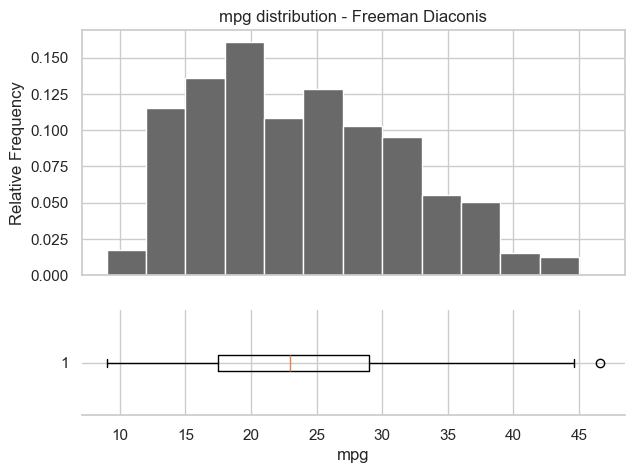

3

In [16]:
histogram_w_whiskers(data, 'mpg')

Looks like the tiniest bit of right skew, though otherwise symmetric as we predicted. We do see the max as an extreme value on the boxplot with whiskers, while it seems that most values are contained within the 'whiskers' (Q1 - 1.5 x IQR, Q3 + 1.5 x IQR). We can also try changing the bin size of the histogram to see if any patterns emerge, but I predict we won't see anything too unusual.

Freeman Diaconis for mpg: 13 bins


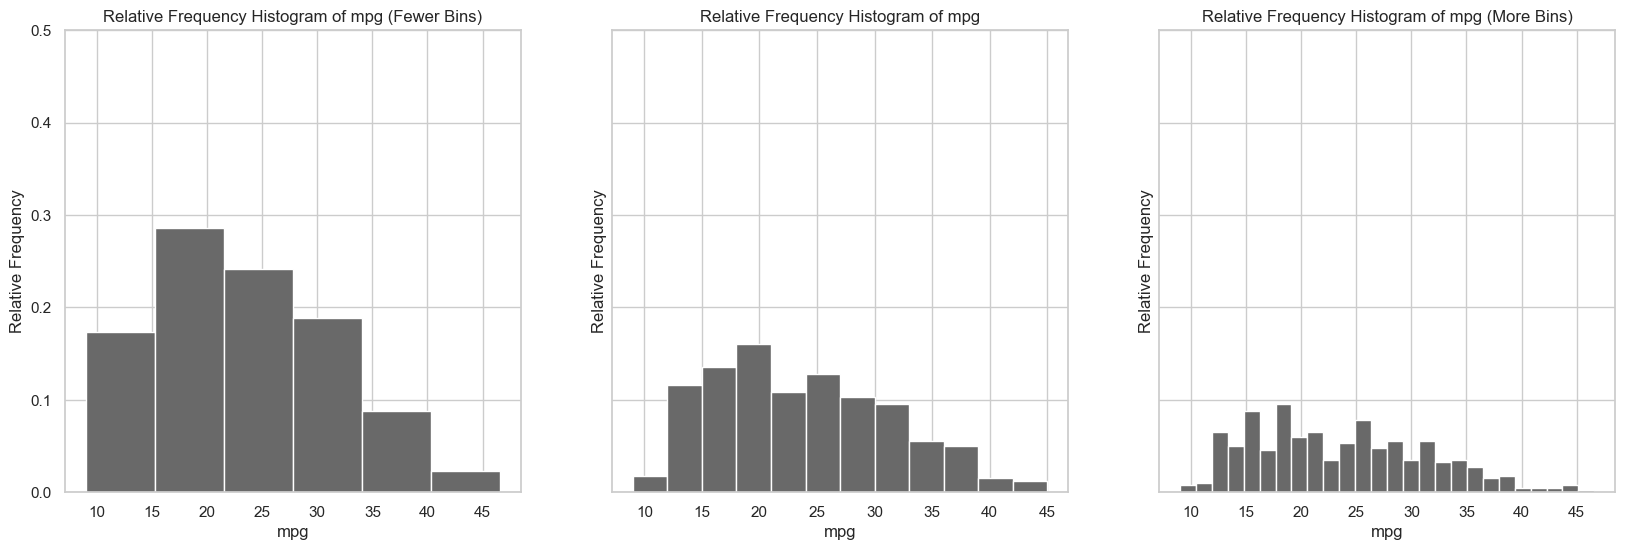

In [17]:
histogram_trio(data, 'mpg', zoom=0.5)

There seems to be a bit of a drop off as we go from about 12-13 down to 11 or so, which is a bit more evident with more bins. Other than that, we see almost a cyclic pattern with the more bins, which I wonder if it's simply because it is too many bins for this variable (remember that the range is not that large).

### Null Model

Now we can look at our Null Model. For our loss function, we want to penalize underestimates and overestimates the same, and penalize larger errors more than smaller errors. This leads us to the Mean Squared Error (MSE) as our loss function. Thus, our baseline model will simply be the mean of mpg since the mean value minimizes MSE. Let's start with reminding ourselves of the summary statistics for mpg.

In [18]:
data['mpg'].describe()

count    398.000000
mean      23.514573
std        7.815984
min        9.000000
25%       17.500000
50%       23.000000
75%       29.000000
max       46.600000
Name: mpg, dtype: float64

Since the mean is 23.5, we can predict that a car will have an $mpg$ rating of 23.5. Now we can create 95% error bounds as well. Remembering that our histogram of $mpg$ in our single variable analysis was fairly symmetric, we can use standard deviation to find the bounds as ($\hat{y}$ - 1.96 * s, $\hat{y}$ + 1.96 * s), where $\hat{y}$ is the predictive value for the model/mean (using $\bar{y}$ - the actual mean), and s is the standard deviation.

In [19]:
mpg_mean = np.mean(data['mpg'])
mpg_std = np.std(data['mpg'])

lower = mpg_mean - 1.96 * mpg_std
upper = mpg_mean + 1.96 * mpg_std

print(f'({lower}, {upper})')

(8.21450110422372, 38.81464462441949)


So we predict that there's a 95% chance a car's $mpg$ rating will be between 8.2 and 38.8 or so.

## 1.3 - Build the linear model

* this is going to be the bulk of the code and discussion
* we are more interested in *process* than a particular RMSE, ie, are you doing the right things?

Now that we have our null model, we can start looking at something more complicated like the linear model. Just as a reminder, our findings from pairwise EDA with the target variable mpg showed roughly these relationships:

* Cylinders - Numeric variable, strong negative (-) correlation with mpg.
* Displacement - Numeric variable, strong negative (-) correlation with mpg.
* Horsepower - Numeric variable, strong negative (-) correlation with mpg.
* Weight - Numeric variable, very strong negative (-) correlation with mpg.
* Acceleration - Numeric variable, weak to moderate positive (+) correlation with mpg. 
* Model Year - Numeric variable, moderate to strong positive (+) correlation with mpg.
* Origin - Categorical variable encoded as a numeric variable, moderate to strong positive (+) correlation.
* Car Name - Categorical variable, no correlation found during EDA.

Before we begin the modeling, we need to transform any categorical variables into dummy variables. This really only applies to origin and car name. Because there are 305 unique values for car name, transforming this variable to include in a linear model seems a bit silly. Having a linear model with 305+ variables doesn't really make sense.

I could try creating the one hot encoding for brand name instead. When I did EDA for mpg vs car name, we saw there were 37 unique brands, give or take a few typos. That still doesn't seem super reasonable to me however.

According to [Cars.com](https://www.cars.com/articles/which-automaker-has-the-best-mpg-cars-431460/), most major car brands averaged an mpg rating of between 20-30 mpg in 2019. This includes Toyota, Volkswagen, Ford, etc. Now remember that this dataset only covers model years from 1970-1982 though, so I'll take this domain knowledge with a grain of salt. 

However, what I'll conclude is that car name is just not a very important variable to include in this model - we saw from our EDA as well that there are other, more important variables in the dataset that strongly correlate with mpg, and will likely be better predictors for mpg than car name.

For now I'll stick with transforming just origin.

In [20]:
data = pd.concat([data, pd.get_dummies(data['origin'], prefix='region')], axis=1)

Here I am using the `models.py` file to perform the modeling

In [21]:
import models

Now on to the linear model. We start with an "all variables in" model at first, (again I won't include car name for reasons stated above). For origin, I'm leaving "region 1" out of the model since that effect gets included in the interpretation of the intercept coefficient $\beta_{0}$ Note I'm using the bootstrap to generate posteriors for the coefficients, $R^2$, and $\sigma$ so that we can get credible intervals for each:

In [22]:
model = 'mpg ~ cylinders + displacement + horsepower + weight + acceleration + model_year + region_2 + region_3'
result_all = models.bootstrap_linear_regression(model, data=data)
models.describe_bootstrap_lr(result_all)

,,,95% BCI</strong,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong
,$\beta_{0}$,-18.73,-29.00,-8.92
cylinders,$\beta_{1}$,2.79,1.70,3.89
displacement,$\beta_{2}$,2.84,1.91,4.07
horsepower,$\beta_{3}$,-0.42,-1.02,0.12
weight,$\beta_{4}$,0.02,0.01,0.04
acceleration,$\beta_{5}$,-0.01,-0.04,0.01
model_year,$\beta_{6}$,-0.01,-0.01,-0.01
region_2,$\beta_{7}$,0.10,-0.18,0.34
region_3,$\beta_{8}$,0.78,0.68,0.87


The coefficient of determination, $R^2$, is 0.82, meaning about 82% of the variability in mpg is explained by this model. Our error of regression, $\sigma$ is 3.31, less than half of the null model's standard deviation of 7.81.

To summarize the other coefficients using a causal interpretation:

* cylinders - every additional cylinder adds 2.79 to mpg.
* displacement - an additional point of displacement adds 2.84 to mpg.
* horsepower - for every additional point of horsepower, subtract 0.42 from mpg.
* weight - each additional pound adds 0.02.
* acceleration - every additional point subtracts 0.01 from mpg.
* model_year - each year subtracts 0.01 from mpg.
* region_2 - if a car was made in region 2, add 0.10 to mpg.
* region_3 - if a car was made in region 3, add 0.78 to mpg.


Let's look at improving the model now. Ideally we want to reduce the amount of features we have, while retaining the same information in our "all in" model. We can make predictions using our domain knowledge from part 1 as to whether each variable is likely to be positive or negative, and compare with our estimated values for this model.

In [23]:
predictions = {
    'cylinders': '-',
    'displacement': '-',
    'horsepower': '-',
    'weight': '-',
    'acceleration': '+',
    'model_year': '+',
    'region_2': '+',
    'region_3': '+'
}

models.evaluate_coefficient_predictions(predictions, result_all)

cylinders P(<0)=0.000 (weak)
displacement P(<0)=0.000 (weak)
horsepower P(<0)=0.910 (strong)
weight P(<0)=0.000 (weak)
acceleration P(>0)=0.180 (weak)
model_year P(>0)=0.000 (weak)
region_2 P(>0)=0.870 (strong)
region_3 P(>0)=1.000 (strong)


We can see here that cylinders, displacment, and weight all show weak signs of being negative, while acceleration and model_year show weak signs of being positive. Horsepower is very likely to be negative, while region_2 and region_3 are very likely to be positive.

From *Fundamentals, Page 785*, we can refer to our nifty table to evaluate our coefficient signs and determine which ones should be kept in our model. We will remove any coefficients with an unexpected/unpredicted sign where the credible bounds does include 0 - namely just acceleration. For unexpected signs that do not include 0 in the bounds - cylinders, displacement, weight, and model_year, we need to re-examine whether these should be kept in the model.

From our EDA in part 1, we saw that cylinders, displacement, and weight were very strongly negatively correlated with mpg, so we'd expect our predicted signs to match the data. However, we also know from looking at our EDA of displacement that the displacement of a car is directly dependent on how many cylinders the car has. There is likely some multicollinearity going on here.

We can look at Pearson's correlation coefficient between cylinders and displacement to see how highly correlated they are with each other, I'm predicting a value close to 1.

In [24]:
stats.pearsonr(data['cylinders'], data['displacement'])[0]

0.9507213901392411

We do in fact see a very high correlation, about 95%. In my opinion, one of these variables should be removed from the model. I'll choose to remove cylinders since its correlation (in absolute terms) with mpg was just slightly lower than displacement vs mpg, plus I think working with the continuous variable of displacement will be easier going forward.

I'll keep weight in the model for now but may need to re-examine this variable again later. For model_year, we saw a moderate to strong positive correlation with mpg during our pairwise EDA analysis. I'll also keep this variable in the model for now.

Next we'll look at residuals for the numeric variable in the model - cylinders, displacement, horsepower, weight, acceleration, and model_year. Not this `plot_residuals` function comes from the Lab 10 Solution.

In [25]:
def plot_residuals(result, variables):
    figure = plt.figure(figsize=(20,6))

    # variables = ['displacement', 'horsepower', 'weight', 'model_year']

    plots = len( variables)
    rows = (plots // 3) + 1

    residuals = np.array([r[0] for r in result['residuals']])
    limits = max(np.abs(residuals.min()), residuals.max())
    
    n = result["n"]
    for i, variable in enumerate( variables):
        axes = figure.add_subplot(rows, 3, i + 1)

        keyed_values = sorted(zip(data[variable].values, residuals), key=lambda x: x[ 0])
        ordered_residuals = [x[ 1] for x in keyed_values]

        axes.plot(list(range(0, n)), ordered_residuals, '.', color="dimgray", alpha=0.75)
        axes.axhline(y=0.0, xmin=0, xmax=n, c="firebrick", alpha=0.5)
        axes.set_ylim((-limits, limits))
        axes.set_ylabel("residuals")
        axes.set_xlabel(variable)

    plt.show()
    plt.close()
    
    return residuals

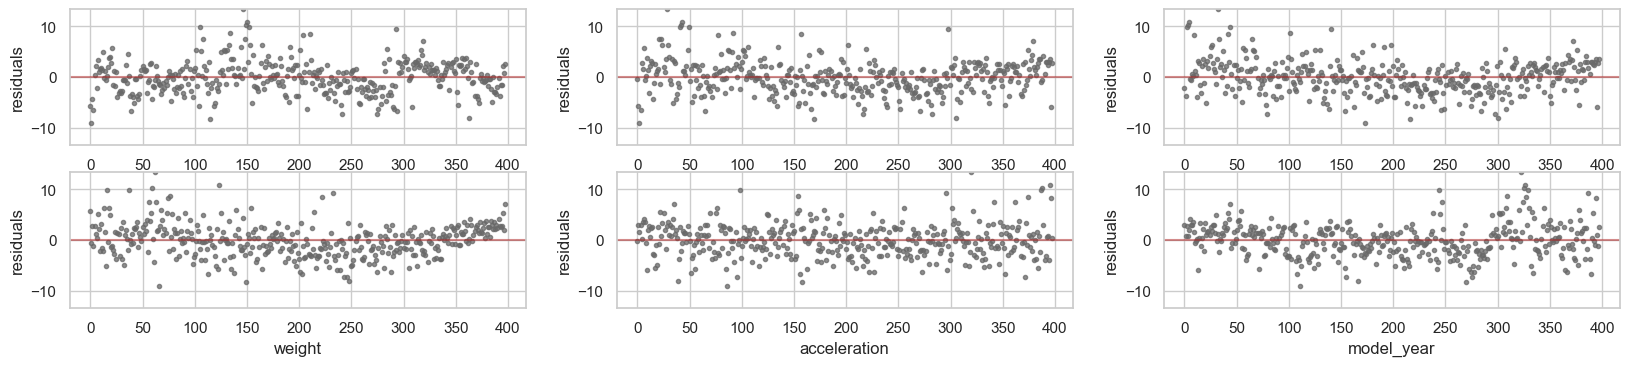

In [26]:
residuals_all = plot_residuals(result_all, ['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'model_year'])

Our residual plots actually don't look too bad. For weight I might be inclined to say we see a slight non-linear pattern - the plot dips a bit and then rises again. Model year is also interesting, we sort of see the variability in the residuals increase for higher values in model year/cars made in later years. Cylinders has a sort of sine wave pattern, but I'm opting to remove it from the model, I won't worry about it for now.

At this point I won't attempt any transformations of the variables or interaction terms. Let's first look at the new model which does not include cylinders or acceleration.

In [27]:
model = 'mpg ~ displacement + horsepower + weight + model_year + region_2 + region_3'
result_2 = models.bootstrap_linear_regression(model, data=data)
models.describe_bootstrap_lr(result_2)

,,,95% BCI</strong,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong
,$\beta_{0}$,-17.84,-23.80,-9.64
displacement,$\beta_{1}$,2.75,1.37,4.10
horsepower,$\beta_{2}$,2.76,1.78,3.95
weight,$\beta_{3}$,0.02,0.00,0.03
model_year,$\beta_{4}$,-0.02,-0.04,0.01
region_2,$\beta_{5}$,-0.01,-0.01,-0.01
region_3,$\beta_{6}$,0.78,0.67,0.87
,,,,
Metrics</strong,Mean</strong,Lo</strong,Hi</strong,


We see that our $R^2$ and $\sigma$ values remain unchanged from the "all in" model. Horsepower is now positive, while region_2 is now barely negative. Most of the other variable coefficients remained roughly the same. However, our bounds for weight and model_year now include 0. This is a little confusing since we saw in EDA that weight and mpg are highly (negatively) correlated, so I'd expect weight to have a larger coefficient here.

Since I was on the fence about keeping model_year in the model last time, I'll opt to remove it to see what effect that has on the model. I'll keep weight still, but may try to remove region_2 as well, since it hovers around 0 and we expected it to still be positive.

Looking at the residuals again:

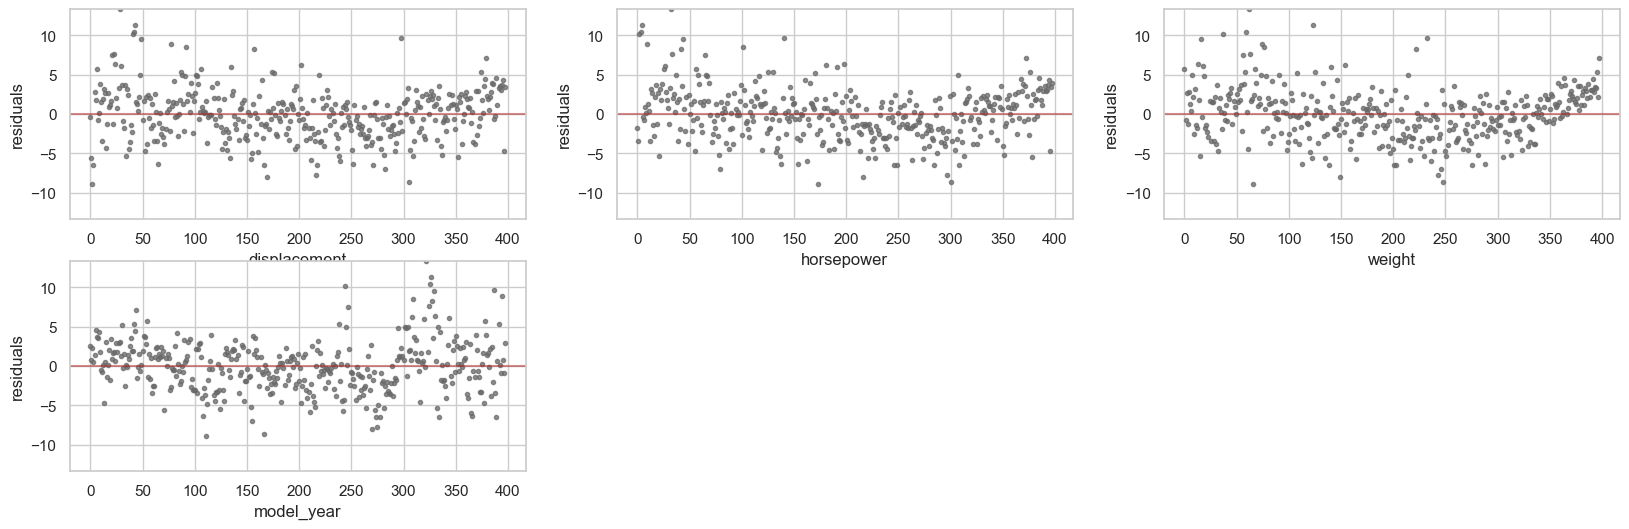

In [28]:
residuals2 = plot_residuals(result_2, ['displacement', 'horsepower', 'weight', 'model_year'])

I think we are seeing a few more extreme points in displacement and weight residual plots, while horsepower seems similar to the original model. Model year residuals increase, almost linearly, as model year increases.

Let's try our new model without weight or region_2:

In [29]:
model = 'mpg ~ displacement + horsepower + weight + region_3'
result_3 = models.bootstrap_linear_regression(model, data=data)
models.describe_bootstrap_lr(result_3)

,,,95% BCI</strong,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong
,$\beta_{0}$,43.62,41.67,46.20
displacement,$\beta_{1}$,2.16,0.84,3.53
horsepower,$\beta_{2}$,-0.00,-0.01,0.01
weight,$\beta_{3}$,-0.05,-0.08,-0.03
region_3,$\beta_{4}$,-0.01,-0.01,-0.00
,,,,
Metrics</strong,Mean</strong,Lo</strong,Hi</strong,
$\sigma$,4.20,3.85,4.51,
$R^2$,0.71,0.68,0.76,


The $R^2$ went down from 0.82 to 0.71 and the $\sigma$ increased from 3.31 to 4.20. Getting further away from our goal of improving, so for now I'll opt to put weight and region_2 back into the model.

I have reason to believe horsepower and acceleration may interact to affect mpg, so I'll try adding an interaction term here with the results we found from the second model (without cylinders and acceleration).

In [30]:
model = 'mpg ~ displacement + horsepower + weight + model_year + region_2 + region_3 + horsepower:acceleration'
result_4 = models.bootstrap_linear_regression(model, data=data)
models.describe_bootstrap_lr(result_4)

,,,95% BCI</strong,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong
,$\beta_{0}$,-16.68,-24.82,-10.11
displacement,$\beta_{1}$,2.50,1.34,3.88
horsepower,$\beta_{2}$,2.59,1.83,3.58
weight,$\beta_{3}$,0.01,-0.01,0.02
model_year,$\beta_{4}$,-0.01,-0.03,0.03
region_2,$\beta_{5}$,-0.01,-0.01,-0.00
region_3,$\beta_{6}$,0.77,0.68,0.86
horsepower:acceleration,$\beta_{7}$,-0.00,-0.00,-0.00
,,,,


The $R^2$ went up ever so slightly to 0.83, while the $\sigma$ decreased from 3.31 to 3.29. Our coefficient for this interaction term is -0.00, which obviously is dubious - surely there are rounding errors here. I don't think this term is worth including in the final model. Note that the coefficient for horsepower changes very wildly from one model to the next, indicating it likely is not truly an independent variable from other variables in the model.

Let's try an interaction with displacement and weight. I theorized from EDA that both variables could be good predictors of mpg, so it stands to reason they might interact to affect mpg as well.

In [31]:
model = 'mpg ~ displacement + horsepower + weight + model_year + region_2 + region_3 + displacement:weight'
result_5 = models.bootstrap_linear_regression(model, data=data)
models.describe_bootstrap_lr(result_5)

,,,95% BCI</strong,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong
,$\beta_{0}$,-5.32,-13.27,0.65
displacement,$\beta_{1}$,1.63,0.78,2.54
horsepower,$\beta_{2}$,1.17,0.27,2.39
weight,$\beta_{3}$,-0.06,-0.08,-0.05
model_year,$\beta_{4}$,-0.04,-0.06,-0.02
region_2,$\beta_{5}$,-0.01,-0.01,-0.01
region_3,$\beta_{6}$,0.81,0.73,0.89
displacement:weight,$\beta_{7}$,0.00,0.00,0.00
,,,,


Our $R^2$ went up a bit to 0.86, and $\sigma$ went down to 2.94. Adding terms to a model never decreases the $R^2$ however, so an adjusted $R^2$ metric may be more useful to look at here. (This function taken from *Fundamentals, Page 779*)

In [32]:
def adjusted_r_squared(result):
    adjustment = (result['n'] - 1)/ (result['n'] - len(result['coefficients']) - 1 - 1)
    return 1 - (1 - result['r_squared']) * adjustment

Let's compare the adjusted $R^2$ for this model to the "best" model we have so far, model 2.

In [33]:
print(adjusted_r_squared(result_2))
print(adjusted_r_squared(result_5))

0.8195893698466636
0.8576174320944616


The adjusted $R^2$ values are pretty much the same as the normal $R^2$ values for each model, where the model with the displacement-weight interaction term increases the $R^2$ from 0.82 to 0.86, and decreases the $\sigma$ from 3.31 to 2.94. My problem however is that the coefficient is effectively 0, as is region_2.

Let's remove this interaction term. Maybe a transformation would be better here rather than an interaction term. Could mpg go up at a decreasing rate with increasing/later model years?

In [34]:
data['model_year_sqrt'] = data['model_year'].apply(np.sqrt)

In [35]:
model = 'mpg ~ displacement + horsepower + weight + model_year_sqrt + region_2 + region_3'
result_6 = models.bootstrap_linear_regression(model, data=data)
models.describe_bootstrap_lr(result_6)

,,,95% BCI</strong,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong
,$\beta_{0}$,-76.64,-90.11,-60.65
displacement,$\beta_{1}$,2.74,1.50,3.86
horsepower,$\beta_{2}$,2.76,1.56,3.66
weight,$\beta_{3}$,0.02,0.00,0.03
model_year_sqrt,$\beta_{4}$,-0.02,-0.04,0.00
region_2,$\beta_{5}$,-0.01,-0.01,-0.01
region_3,$\beta_{6}$,13.56,11.70,15.18
,,,,
Metrics</strong,Mean</strong,Lo</strong,Hi</strong,


Not much better than what we had. How about diminishing returns on weight?

In [36]:
data['weight_sqrt'] = data['weight'].apply(np.sqrt)

In [37]:
model = 'mpg ~ displacement + horsepower + weight_sqrt + model_year + region_2 + region_3'
result_7 = models.bootstrap_linear_regression(model, data=data)
models.describe_bootstrap_lr(result_7)

,,,95% BCI</strong,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong
,$\beta_{0}$,3.34,-4.00,10.49
displacement,$\beta_{1}$,2.58,1.51,3.73
horsepower,$\beta_{2}$,2.34,1.44,3.29
weight_sqrt,$\beta_{3}$,0.02,0.01,0.03
model_year,$\beta_{4}$,-0.02,-0.04,0.00
region_2,$\beta_{5}$,-0.80,-0.95,-0.68
region_3,$\beta_{6}$,0.80,0.72,0.91
,,,,
Metrics</strong,Mean</strong,Lo</strong,Hi</strong,


We do see a slight improvement, our $R^2$ up to 0.84 and $\sigma$ down to 3.17. I'm still confused why the variables opt to hover around zero though. Based on EDA, these variables had a much stronger correlation with mpg.

For now let's consider this model the "best" and improve on it. Here are the residuals.

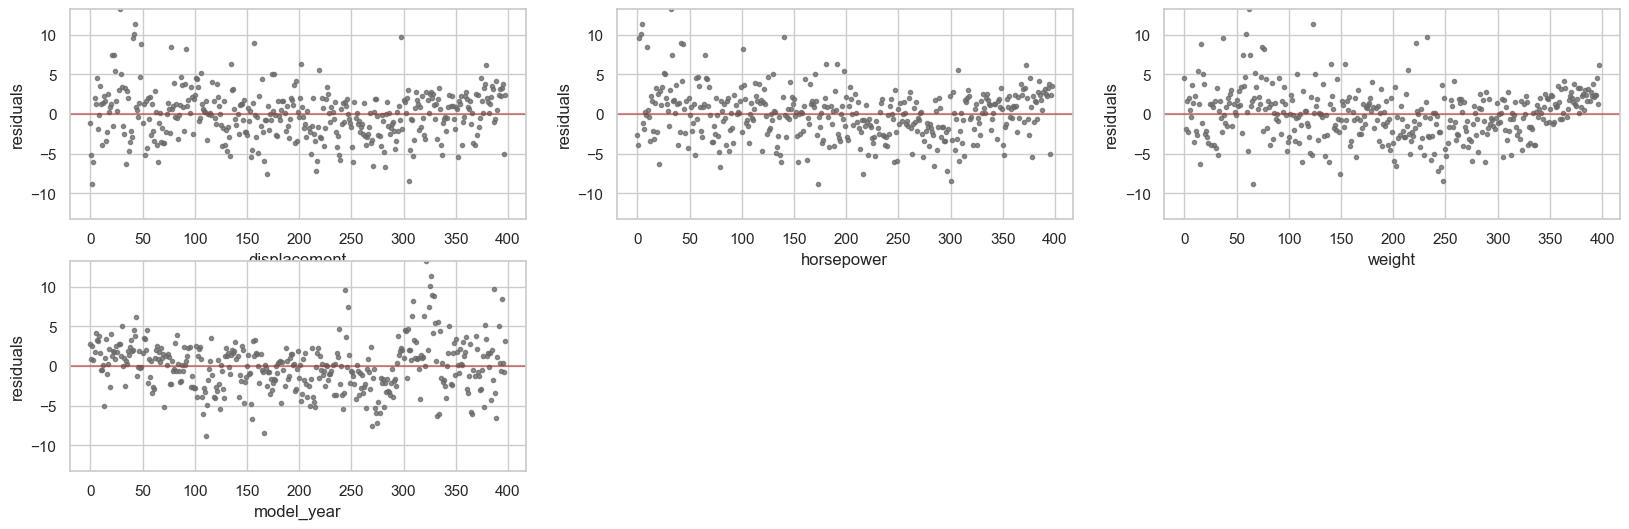

In [38]:
residuals7 = plot_residuals(result_7, ['displacement', 'horsepower', 'weight', 'model_year'])

Nothing too different than what we've already seen. Model year still has somewhat high variability for larger values, but we do not see the linearly increasing pattern we saw in the last model. It doesn't seem to be overly concerning, in my opinion, as there is not a hugely obvious pattern here, like we saw in the bmi variable during Lab 10.

Let's add back acceleration to this model to see how it compares.

In [39]:
model = 'mpg ~ displacement + horsepower + weight_sqrt + acceleration + model_year + region_2 + region_3'
result_8 = models.bootstrap_linear_regression(model, data=data)
models.describe_bootstrap_lr(result_8)

,,,95% BCI</strong,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong
,$\beta_{0}$,1.65,-6.64,8.42
displacement,$\beta_{1}$,2.57,1.62,3.95
horsepower,$\beta_{2}$,2.33,1.33,3.18
weight_sqrt,$\beta_{3}$,0.02,0.01,0.03
acceleration,$\beta_{4}$,-0.01,-0.03,0.02
model_year,$\beta_{5}$,-0.85,-1.02,-0.69
region_2,$\beta_{6}$,0.14,-0.13,0.39
region_3,$\beta_{7}$,0.81,0.72,0.91
,,,,


About the same. Since the acceleration coefficient is negative here when we expected a positive sign, and the credible bounds include zero, I will opt to remove it again.

Finally, I'll try adding another interaction term. From EDA we saw that displacement and weight are likely to be good predictors of mpg. Let's try displacement and the square root of weight.

In [40]:
model = 'mpg ~ displacement + horsepower + weight_sqrt + model_year + region_2 + region_3 + displacement:weight_sqrt'
result_9 = models.bootstrap_linear_regression(model, data=data)
models.describe_bootstrap_lr(result_9)

,,,95% BCI</strong,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong
,$\beta_{0}$,20.80,13.69,30.81
displacement,$\beta_{1}$,1.62,0.69,2.79
horsepower,$\beta_{2}$,1.13,0.14,2.17
weight_sqrt,$\beta_{3}$,-0.11,-0.14,-0.07
model_year,$\beta_{4}$,-0.03,-0.06,-0.01
region_2,$\beta_{5}$,-1.08,-1.21,-0.96
region_3,$\beta_{6}$,0.81,0.73,0.92
displacement:weight_sqrt,$\beta_{7}$,0.00,0.00,0.00
,,,,


Similar to the other interaction terms we tried, the coefficient is effectively zero, so I won't include it in the final model.

I'll attempt one more iteration to try improving the model. From our [domain knowledge](https://www.carthrottle.com/news/redux-why-american-cars-tend-have-big-engines), we see that American cars ("region 1") tend to have larger engines than other countries. Perhaps displacement interacts with region 2 or region 3?

In [41]:
model = 'mpg ~ displacement + horsepower + weight_sqrt + model_year + region_2 + region_3 + displacement:region_2'
result_10 = models.bootstrap_linear_regression(model, data=data)
models.describe_bootstrap_lr(result_10)

,,,95% BCI</strong,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong
,$\beta_{0}$,0.79,-6.01,10.35
displacement,$\beta_{1}$,6.45,1.48,12.53
horsepower,$\beta_{2}$,2.44,1.46,3.67
weight_sqrt,$\beta_{3}$,0.02,0.01,0.03
model_year,$\beta_{4}$,-0.04,-0.09,0.01
region_2,$\beta_{5}$,-0.02,-0.04,0.00
region_3,$\beta_{6}$,-0.76,-0.94,-0.68
displacement:region_2,$\beta_{7}$,0.81,0.71,0.90
,,,,


Not much difference here. What about displacement and region 3?

In [42]:
model = 'mpg ~ displacement + horsepower + weight_sqrt + model_year + region_2 + region_3 + displacement:region_3'
result_11 = models.bootstrap_linear_regression(model, data=data)
models.describe_bootstrap_lr(result_11)

,,,95% BCI</strong,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong
,$\beta_{0}$,2.03,-7.94,9.15
displacement,$\beta_{1}$,2.62,1.45,4.00
horsepower,$\beta_{2}$,4.83,0.47,9.14
weight_sqrt,$\beta_{3}$,0.02,0.01,0.03
model_year,$\beta_{4}$,-0.02,-0.06,0.02
region_2,$\beta_{5}$,-0.02,-0.04,0.00
region_3,$\beta_{6}$,-0.79,-0.91,-0.68
displacement:region_3,$\beta_{7}$,0.81,0.72,0.93
,,,,


Again not any better. We see that weight_sqrt and model_year have small individual effects in the model. What if we combined them?

In [79]:
model = 'mpg ~ displacement + horsepower + weight_sqrt + model_year + region_2 + region_3 + weight_sqrt:model_year'
result_12 = models.bootstrap_linear_regression(model, data=data)
models.describe_bootstrap_lr(result_12)

,,,95% BCI</strong,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong
,$\beta_{0}$,-186.91,-244.60,-134.89
displacement,$\beta_{1}$,2.57,1.17,3.60
horsepower,$\beta_{2}$,1.94,1.12,2.78
weight_sqrt,$\beta_{3}$,0.02,0.00,0.03
model_year,$\beta_{4}$,-0.04,-0.06,-0.02
region_2,$\beta_{5}$,2.91,1.89,4.07
region_3,$\beta_{6}$,3.30,2.62,4.03
weight_sqrt:model_year,$\beta_{7}$,-0.05,-0.06,-0.04
,,,,


That's a bit better. Now our $R^2$ is up from 0.84 to 0.86, and the $\sigma$ went down from 3.17 to 2.96. What about adjusted $R^2$ and the residuals for this model?

In [80]:
print(adjusted_r_squared(result_7))
print(adjusted_r_squared(result_12))

0.8347697453781954
0.8344899920652726


So the adjusted $R^2$ actually didn't increase from our "best" model. How about the residuals?

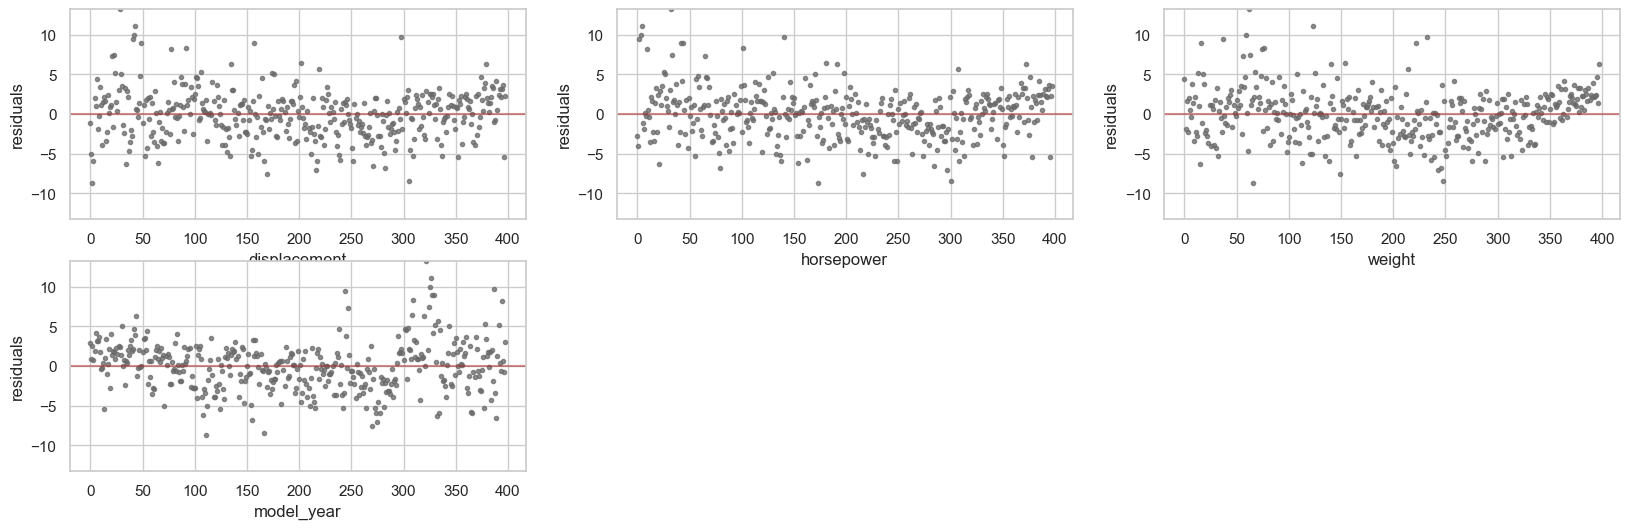

In [81]:
residuals12 = plot_residuals(result_12, ['displacement', 'horsepower', 'weight', 'model_year'])

Pretty much the same. I'll still consider model 7 as the best final model.

Note, I did try a few other transformations such as squaring displacement and such, but these transformations were an attempt to improve the model from a raw numbers perspective, not rooted in any kind of domain knowledge or heuristic as mentioned in class as ways to systematically go about improving a linear model.

One such transformation (squaring displacement) is shown below

In [62]:
data['displacement_sq'] = data['displacement']**2
model = 'mpg ~ displacement_sq + horsepower + weight_sqrt + model_year + region_2 + region_3'
result_13 = models.bootstrap_linear_regression(model, data=data)
models.describe_bootstrap_lr(result_13)

,,,95% BCI</strong,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong
,$\beta_{0}$,5.11,-1.57,11.28
displacement_sq,$\beta_{1}$,2.50,1.52,3.50
horsepower,$\beta_{2}$,2.20,0.92,3.17
weight_sqrt,$\beta_{3}$,0.00,0.00,0.00
model_year,$\beta_{4}$,-0.04,-0.06,-0.01
region_2,$\beta_{5}$,-0.79,-0.90,-0.69
region_3,$\beta_{6}$,0.81,0.74,0.92
,,,,
Metrics</strong,Mean</strong,Lo</strong,Hi</strong,


The model here improves slightly, but now the weight_sqrt coefficient is near zero. One possible reason this coefficient changes so much could be due to multicollinearity. We already saw how the horsepower coefficient also swings wildly from one model to the next.

Any interaction terms, as we've seen tend towards zero, so I don't think adding interaction terms is the way to go here. I've tried several transformations of the, shall we say, "independent" variables with little effect on improving the model too.

I will consider the final/best model I could find as model 7, the one with features displacement, horsepower, weight_sqrt, model_year, region_2, and region_3, but note there could be better models out there that I have not uncovered.

## 1.4 - Describe the final model

* do this when you are completely, finally, and entirely done with building the model. This is a summary, in words, of the final model you would present to stakeholders before putting it into production).
* Look at *Fundamentals* and Labs 10 & 11 if you're not sure what goes here.

As a reminder, the final model is:

In [84]:
model = 'mpg ~ displacement + horsepower + weight_sqrt + model_year + region_2 + region_3'
final = models.bootstrap_linear_regression(model, data=data)
models.describe_bootstrap_lr(final)

,,,95% BCI</strong,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong
,$\beta_{0}$,3.34,-3.90,12.38
displacement,$\beta_{1}$,2.58,1.48,3.72
horsepower,$\beta_{2}$,2.34,1.35,3.33
weight_sqrt,$\beta_{3}$,0.02,0.00,0.03
model_year,$\beta_{4}$,-0.02,-0.04,0.01
region_2,$\beta_{5}$,-0.80,-0.94,-0.66
region_3,$\beta_{6}$,0.80,0.70,0.89
,,,,
Metrics</strong,Mean</strong,Lo</strong,Hi</strong,


The final model can be described as follows:

1. displacement is positive; this is a bit expected. Larger engines for similar cars could have better fuel efficiency.
2. horsepower is positive; this is unexpected. We would think higher horsepower cars leads to worse gas mileage and thus should be negative. Some models did present this coefficient as negative however.
3. weight_sqrt has a slight positive effect on mpg. As weight increases, the mpg increases at a slower rate.
4. model_year is slightly negative which is not too surprising, since this variable only considers a small range of values; we would not expect this variable to have as big as an effect as say displacement.
5. region_2 has a negative effect on mpg.
6. region_3 has a positive effect on mpg, which is supported by the data.

It seems that displacement, horsepower, and region_3 have the overall largest (and positive) effects on mpg, while region_2 has the biggest negative effect.

And here are the residuals:

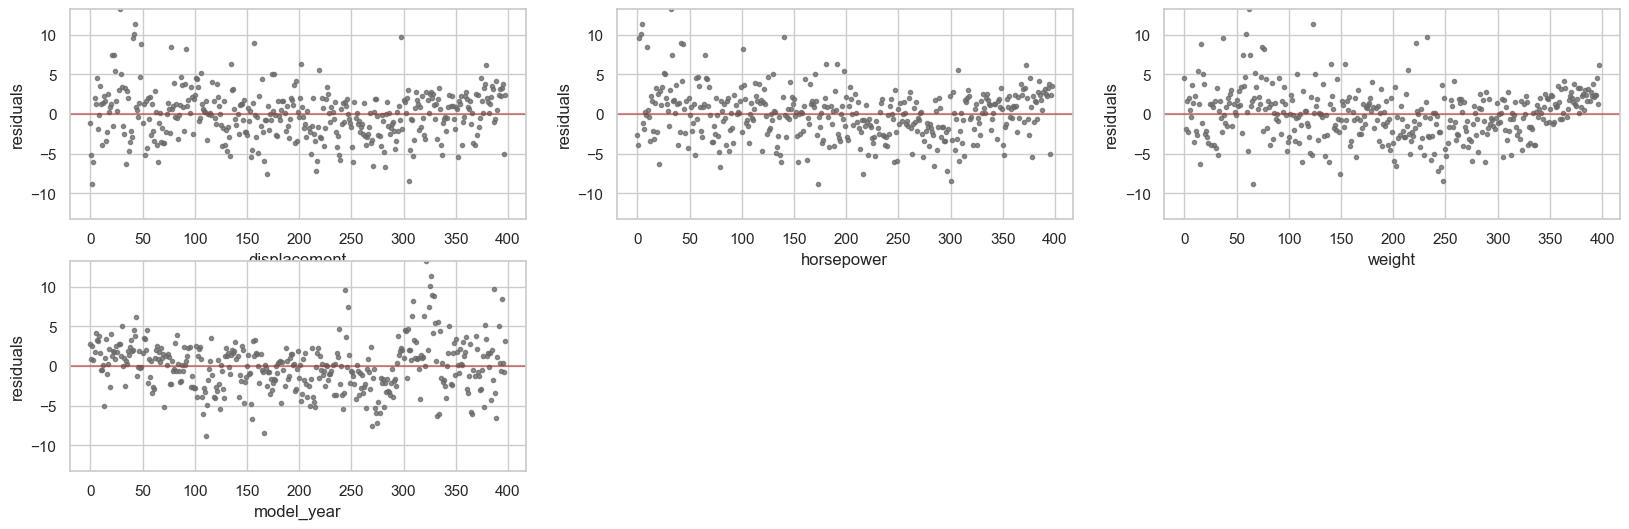

In [85]:
residuals_final = plot_residuals(final, ['displacement', 'horsepower', 'weight', 'model_year'])

The $R^2$ is 0.84, up a bit from the initial "all in" model of 0.82. Our error of regression $\sigma$ is also down, 3.17 in the final model, vs 3.34 in the "all in" model, and about a 40% decrease compared to the standard deviation in the null model of 7.82.

## 1.5 - Use the model

* and compare with the Null Model

Let's make some predictions with the linear model. We will make 3 predictions and compare with the null model. The observations we will use are as follows:

* A car with displacement of 250, horsepower 110, a weight of 3200, made in 1977 from region 2.
* A car with displacement of 379, horsepower 190, a weight of 3500, made in 1981 from region 1.
* A car with displacement 132, horsepower 80, a weight of 2450, made in 1973 from region 3.

Here are the feature vectors:

In [124]:
car_1 = [1, 250, 110, np.sqrt(3200), 77, 1, 0]
car_2 = [1, 379, 190, np.sqrt(3500), 81, 0, 0]
car_3 = [1, 132, 80, np.sqrt(2450), 73, 0, 1]

In [125]:
np.sqrt(final['model'].predict([car_1])[0][0])

30.08442961505739

Because the residuals are fairly symmetric, I will use the 1.96 error bounds

In [ ]:
def bootstrap_prediction(df, model, obs, samples=1000):
    predictions = []
    for i in range(samples):
        bootstrap = df.sample(len(df), replace=True)
        result = models.linear_regression(model, bootstrap)
        predict = result["model"].predict([obs])[0][0]
        error = random.choice(result["residuals"])[0]
        estimate = predict + error
        predictions.append(estimate)
    return predictions

In [89]:
final['model'].predict([car_2])[0][0]

1426.1621962094987



---

**CHECK LIST**

Before you submit this assignent, go back and review the directions to ensure that you have followed each instruction.



* Have you completed every section and answered every question asked?
* For every question, have you described your approach and explained your results?
* Have you checked for spelling and grammar errors?
* Are your code blocks free of any errors?
* Have you *SAVED* your notebook?
* Submit *THIS* notebook to the proper place in Blackboard.